In [1]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import BertForSequenceClassification, BertTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

In [48]:
MODEL_NAME= "beomi/kcbert-base"
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10, problem_type='multi_label_classification')
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

loading configuration file https://huggingface.co/beomi/kcbert-base/resolve/main/config.json from cache at C:\Users\USER/.cache\huggingface\transformers\10de039f2f91b0c6fbd30fad5bf8a7468a20701212ed12f9f5e610edb99c55d1.d8a72131e15fd1d856f1b39abf4eff31d458aeeca0a4192df898ca699ec7d779
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9":

In [4]:
unsmile_labels = ["여성/가족","남성","성소수자","인종/국적","연령","지역","종교","기타 혐오","악플/욕설","clean"]

In [5]:
import pandas as pd
data_path ='C:/Users/USER/Desktop/2021_korean_hate_speech_detection/hs_CORAL/dataset/'
unsmile_train_dataset = pd.read_csv(data_path+"Unsmile_train_dataset.csv")
#unsmile_train_dataset = pd.concat([unsmile_train_dataset['문장'], unsmile_train_dataset['labels']], axis=1)
unsmile_test_dataset = pd.read_csv(data_path+"Unsmile_test_dataset.csv")
#unsmile_test_dataset = pd.concat([unsmile_test_dataset['문장'], unsmile_test_dataset['labels']], axis=1)
unsmile_train_dataset.head(5)

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭,labels
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0,0,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0,0,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0,0,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,1,0,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [58]:
tokenized_train_sentences = tokenizer(list(unsmile_train_dataset['문장']))
tokenized_test_sentences = tokenizer(list(unsmile_test_dataset['문장']))

In [59]:
print(tokenized_train_sentences['input_ids'][-1])

[2, 1367, 9871, 8696, 15837, 4072, 3209, 4053, 4585, 8971, 22104, 2581, 10557, 10667, 4421, 4226, 4525, 29, 1931, 4164, 5527, 4207, 4029, 4059, 15, 3213, 29568, 29568, 4042, 8686, 4503, 4124, 15, 416, 4296, 8705, 1300, 26180, 4072, 8472, 4207, 4029, 15, 20009, 13478, 2173, 4167, 4379, 4184, 15, 1826, 4358, 8705, 3479, 4099, 5020, 9511, 1417, 23424, 4184, 3]


In [7]:
def labels_to_tensor(label_df):

    label_list = list()
    for k in range(len(label_df['labels'])):
        item = label_df['labels'][k]
        tmp_label = list()
        for i in range(1, 30, 3):
            label = int(item[i])
            tmp_label.append(label)
        label_list.append(tmp_label)
    return torch.tensor(label_list, dtype=torch.float64)

In [60]:
tokenized_train_sentences['labels'] = labels_to_tensor(unsmile_train_dataset)
tokenized_test_sentences['labels'] = labels_to_tensor(unsmile_test_dataset)

In [61]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    
    def __len__(self):
        return len(self.encodings)

In [62]:
train_dataset = MyDataset(tokenized_train_sentences)
test_dataset = MyDataset(tokenized_test_sentences)

In [63]:
train_dataset[0]

C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


{'input_ids': tensor([    2,  2458, 15751, 24930, 24351, 29278, 17038, 11631,     3]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=torch.float64)}

In [64]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [78]:
batch_size = 64
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='KcBERT_unsmile', # 학습결과 저장경로
    per_device_train_batch_size=4,
    per_device_eval_batch_size=32,
    evaluation_strategy='epoch',
    num_train_epochs=5,
    logging_steps=500,
    logging_dir='KcBERT_unsmile',
    save_strategy='epoch',
    metric_for_best_model='lrap',
    greater_is_better=True,
    save_total_limit=2,
    load_best_model_at_end=True
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [66]:
from sklearn.metrics import label_ranking_average_precision_score
def compute_metrics(x):
    return {
            'lrap': label_ranking_average_precision_score(x.label_ids, x.predictions),
        }

In [79]:
from transformers import AutoModelForSequenceClassification
num_labels=10 # Label 갯수
model_name = 'beomi/kcbert-base'
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    problem_type="multi_label_classification"
)
model.config.id2label = {i: label for i, label in zip(range(num_labels), unsmile_labels)}
model.config.label2id = {label: i for i, label in zip(range(num_labels), unsmile_labels)}

loading configuration file https://huggingface.co/beomi/kcbert-base/resolve/main/config.json from cache at C:\Users\USER/.cache\huggingface\transformers\10de039f2f91b0c6fbd30fad5bf8a7468a20701212ed12f9f5e610edb99c55d1.d8a72131e15fd1d856f1b39abf4eff31d458aeeca0a4192df898ca699ec7d779
Model config BertConfig {
  "_name_or_path": "beomi/kcbert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL

In [82]:
from transformers import Trainer
#model_path = 'C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/pytorch_model.bin'
#model.load_state_dict(torch.load(model_path))
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model
    args=training_args,                  # 위에서 정의한 Training Arguments
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [81]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [83]:
trainer.train()

***** Running training *****
  Num examples = 4
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 5
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch,Training Loss,Validation Loss,Lrap
1,No log,0.603280,0.469444
2,No log,0.552158,0.298611
3,No log,0.518695,0.277778
4,No log,0.502593,0.286111
5,No log,0.496116,0.322917


***** Running Evaluation *****
  Num examples = 4
  Batch size = 32
Saving model checkpoint to KcBERT_unsmile\checkpoint-1
Configuration saved in KcBERT_unsmile\checkpoint-1\config.json
Model weights saved in KcBERT_unsmile\checkpoint-1\pytorch_model.bin
tokenizer config file saved in KcBERT_unsmile\checkpoint-1\tokenizer_config.json
Special tokens file saved in KcBERT_unsmile\checkpoint-1\special_tokens_map.json
Deleting older checkpoint [KcBERT_unsmile\checkpoint-4] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
***** Running Evaluation *****
  Num examples = 4
  Batch size = 32
Saving model checkpoint to KcBERT_unsmile\checkpoint-2
Configuration saved in KcBERT_unsmile\checkpoint-2\config.json
Model weights saved in K

TrainOutput(global_step=5, training_loss=0.5053779125213623, metrics={'train_runtime': 13.5032, 'train_samples_per_second': 1.481, 'train_steps_per_second': 0.37, 'total_flos': 370026498240.0, 'train_loss': 0.5053779125213623, 'epoch': 5.0})

In [70]:
trainer.save_model()

Saving model checkpoint to KcBERT_unsmile
Configuration saved in KcBERT_unsmile\config.json
Model weights saved in KcBERT_unsmile\pytorch_model.bin
tokenizer config file saved in KcBERT_unsmile\tokenizer_config.json
Special tokens file saved in KcBERT_unsmile\special_tokens_map.json


In [71]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(
    model = model,
    tokenizer = tokenizer,
    device=0,
    return_all_scores=True,
    function_to_apply='sigmoid',
    )

In [72]:
num_labels=len(unsmile_labels) # Label 갯수
model.config.id2label = {i: label for i, label in zip(range(num_labels), unsmile_labels)}
model.config.label2id = {label: i for i, label in zip(range(num_labels), unsmile_labels)}

In [84]:
results_list = list()
for result in pipe("이래서 여자는 게임을 하면 안된다")[0]:
    results_list.append(result['score'])
    print(result)

{'label': '여성/가족', 'score': 0.34258362650871277}
{'label': '남성', 'score': 0.37717923521995544}
{'label': '성소수자', 'score': 0.2397957295179367}
{'label': '인종/국적', 'score': 0.3074401021003723}
{'label': '연령', 'score': 0.30246633291244507}
{'label': '지역', 'score': 0.3914913237094879}
{'label': '종교', 'score': 0.33930450677871704}
{'label': '기타 혐오', 'score': 0.4107763171195984}
{'label': '악플/욕설', 'score': 0.4184565544128418}
{'label': 'clean', 'score': 0.3489697575569153}


C:\Users\USER\AppData\Roaming\Python\Python36\site-packages\transformers\pipelines\base.py:1077: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [74]:
def get_predicated_label(output_labels, min_score):
    labels = []
    for label in output_labels:
        if label['score'] > min_score:
            labels.append(1)
        else:
            labels.append(0)
    return labels

In [85]:
from transformers.pipelines.base import KeyDataset

predicated_labels = []

for sentence in unsmile_test_dataset['문장']:
    for out in pipe(sentence):
        predicated_labels.append(get_predicated_label(out, 0.5))

In [86]:
from sklearn.metrics import classification_report
unsmile_test = pd.read_csv(data_path+"Unsmile_test_dataset.csv")
print(classification_report(labels_to_tensor(unsmile_test), predicated_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       394
           1       0.00      0.00      0.00       334
           2       0.00      0.00      0.00       280
           3       0.12      0.00      0.00       426
           4       0.00      0.00      0.00       146
           5       0.00      0.00      0.00       260
           6       0.20      0.00      0.01       290
           7       0.14      0.01      0.01       134
           8       0.35      0.01      0.01       786
           9       0.26      0.60      0.36       935

   micro avg       0.26      0.14      0.18      3985
   macro avg       0.11      0.06      0.04      3985
weighted avg       0.16      0.14      0.09      3985
 samples avg       0.15      0.15      0.15      3985



C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.59      0.83      0.69       160
           1       0.57      0.45      0.50       189
           2       0.76      0.59      0.66       122

    accuracy                           0.62       471
   macro avg       0.64      0.62      0.62       471
weighted avg       0.62      0.62      0.61       471



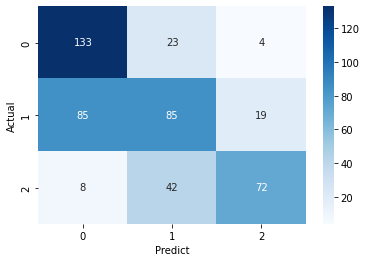

In [17]:
## classification_report
from sklearn.metrics import classification_report
y_test = test_dataset.labels
preds_list = predictions[0].argmax(-1)
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [18]:
from coral_pytorch.dataset import proba_to_label

def compute_mae_and_mse(label, preds_list):

    mae, mse = 0., 0.
    num_examples = len(label)
    targets = torch.tensor(label)
    predicted_labels = torch.tensor(preds_list)
    
    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

    mae = mae / num_examples
    mse = mse / num_examples
    return mae, mse

In [19]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.4098)
tensor(0.4607)


C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
